In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.functional import F
from torch_geometric.nn import to_hetero
from torch_geometric.loader import DataLoader

#### Set random seed

In [2]:
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#### Set device and parameters

In [3]:
# Set hyper-parameters
input_dim = 8
hidden_dim = 64
output_dim = 1

# Set batch size
batch_size = 24

# Set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Directory of the dataset
train_dir = f'train_dataset'
test_dir = f'test_dataset'

#### Load train and test data

In [4]:
from CustomDataset import CustomDataset

In [5]:
train_dataset = CustomDataset(root=train_dir, data_list=[])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(root=test_dir, data_list=[])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Load model

In [6]:
from GNNModel import GNNModel

model = GNNModel(input_dim, hidden_dim, output_dim)
model = to_hetero(module=model, 
                  metadata=train_loader.dataset[0].metadata(), 
                  aggr='mean')
model.to(device)
model

GraphModule(
  (conv1): ModuleDict(
    (node__branch__node): GCNConv(8, 64)
    (node__trafo__node): GCNConv(8, 64)
  )
  (bn1): ModuleDict(
    (node): BatchNorm(64)
  )
  (in1): ModuleDict(
    (node): InstanceNorm(64)
  )
  (ln1): ModuleDict(
    (node): LayerNorm(64, affine=True, mode=graph)
  )
  (conv2): ModuleDict(
    (node__branch__node): GCNConv(64, 64)
    (node__trafo__node): GCNConv(64, 64)
  )
  (bn2): ModuleDict(
    (node): BatchNorm(64)
  )
  (in2): ModuleDict(
    (node): InstanceNorm(64)
  )
  (ln2): ModuleDict(
    (node): LayerNorm(64, affine=True, mode=graph)
  )
  (conv3): ModuleDict(
    (node__branch__node): GCNConv(64, 1)
    (node__trafo__node): GCNConv(64, 1)
  )
  (bn3): ModuleDict(
    (node): BatchNorm(1)
  )
  (in3): ModuleDict(
    (node): InstanceNorm(1)
  )
  (ln3): ModuleDict(
    (node): LayerNorm(1, affine=True, mode=graph)
  )
)

#### Train model

In [7]:
# Set number of epochs
epochs = 1000

# Set optimizer
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001, 
    weight_decay=1e-4
)

# Set model to training mode
model.train()

# Model training
epoch_loss = []
start_time = time.time()

for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)
        optimizer.zero_grad()
        out = model(loader.x_dict, loader.edge_index_dict)
        loss = F.mse_loss(out['node'][loader.mask], loader['node'].y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

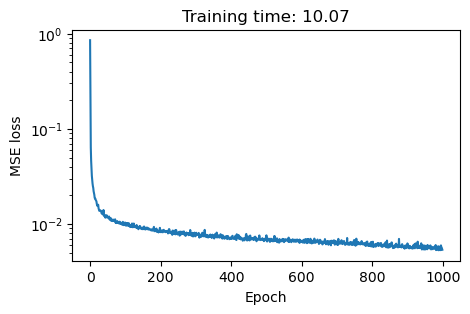

In [8]:
plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')